## Дипломный проект "Телеком. Прогнозирование оттока клиентов"

### Задача
Построить модель машинного обучения для прогнозирования оттока клиентов компании «Ниединогоразрыва.ком»

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).


А также у пользователя есть возможноть подключить дополнительные услуги


3. Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
4. Выделенная линия технической поддержки (*TechSupport*);
5. Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
6. Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

### Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np

import datetime
from sklearn.model_selection import train_test_split,GridSearchCV
import seaborn as sns

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 

from sklearn.metrics import roc_curve #график auc_roc
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle #перемешивание при семплировании 

from sklearn.preprocessing import StandardScaler #масштабирование количественных признаков
pd.options.mode.chained_assignment = None

from sklearn.tree import DecisionTreeClassifier #дерево решений 
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression

### Импорт библиотек градинетного бутинга

In [2]:
try:
    %pip install lightgbm
except:
    !pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
try:
    %pip install catboost
except: 
    !pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

In [5]:
from numpy.random import RandomState
rdm = RandomState(250722)

In [6]:
from lightgbm import LGBMClassifier

### Загрузка данных

In [7]:
try:
    data_personal = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/diploma/datasets/final_provider/personal.csv')
    data_contract = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/diploma/datasets/final_provider/contract.csv')
    data_phone = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/diploma/datasets/final_provider/phone.csv')
    data_internet = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/diploma/datasets/final_provider/internet.csv')
except:
    data_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    data_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    data_phone = pd.read_csv('/datasets/final_provider/phone.csv')
    data_internet = pd.read_csv('/datasets/final_provider/internet.csv')

### Получение информации  о датасетах

In [8]:
def info_df(personal,contract,phone,internet):
    df_all= [personal,contract,phone,internet]
    for i in df_all:
        display(i.head())
        i.info()
        display(i.duplicated().sum())
        display(i.shape)

In [9]:
info_df(data_contract,data_personal,data_phone,data_internet)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


0

(7043, 8)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


0

(7043, 5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


0

(6361, 2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


0

(5517, 8)

##  Предобработка данных

### Приведение названий колонок к нижнему регистру

In [10]:
def change_col(df:pd.DataFrame):
    df.columns = df.columns.str.lower()

In [11]:
df_lst = [data_contract,data_personal,data_phone,data_internet]
for elem in df_lst:
    change_col(elem)

### Cоединение таблиц

In [12]:
data = data_contract.merge(data_personal,on = 'customerid', how = 'left')
data = data.merge(data_phone,on = 'customerid', how = 'left')
data = data.merge(data_internet,on = 'customerid', how = 'left')

In [13]:
def info(df: pd.DataFrame):
    print(f'Информация:')
    print(f'Первые {len(df.head())} строк:')
    display(df.head())
    print('Общая информация:')
    df.info()
    print(f'Количество дубликатов: {df.duplicated().sum()}')

In [14]:
info(data)

Информация:
Первые 5 строк:


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


Общая информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  multiplelines     6361 non-null   object 
 13  internetservice   5517 non-null   object 
 14  onlinesecurity    5517 non-null   object 
 15  onlinebackup      5517 non-null   object 
 16  deviceprotection  5517 n

### Нахождение времени жизни клиента

In [15]:
data['begindate'] = pd.to_datetime(data['begindate'])

In [16]:
# Замена значений NO из enddate на дату снятияя показаний -- 2020-02-01
data.loc[data['enddate'] == 'No', 'enddate'] = pd.to_datetime('2020-02-01')
data.enddate = pd.to_datetime(data.enddate)

In [17]:
data.enddate.value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: enddate, dtype: int64

In [18]:
#Найдем количество дней, в течение которых человек был клиентом компании
data['sumdays'] = (data['enddate'] - data['begindate']).dt.days

In [19]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,sumdays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,NaN,DSL,No,Yes,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,NaN,DSL,Yes,No,Yes,Yes,No,No,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,61


### Работа  с пропусками и  пробелами

In [20]:
data.isna().sum()

customerid             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
gender                 0
seniorcitizen          0
partner                0
dependents             0
multiplelines        682
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
sumdays                0
dtype: int64

In [21]:
 #Пробелы скорее всего вызваны  тем, что это совсем новые пользователи, по  которым нет данных. 
data[data["totalcharges"] == " "]
print("Доля пропущенных значений ", len(data[data["totalcharges"] == " "]) / len(data["totalcharges"]*100))

Доля пропущенных значений  0.001561834445548772


In [22]:
#Удалим пользователей,у которых суммарное число контракта равнонулю дней,тк.их доля меньше 1 процента
data = data[data['sumdays'] != 0]

In [23]:
#  Заменим все пропущенные значения на NO
def data_fillna (data:pd.DataFrame, colname: str):
    data[colname] = data[colname].fillna ('No')

In [24]:
lst_to_fiil = ['internetservice',
                'onlinesecurity',
                'onlinebackup',
                'deviceprotection',
                'techsupport',
                'streamingtv',
                'streamingmovies',
              'multiplelines']
for elem in lst_to_fiil:
    data_fillna(data, elem)

In [25]:
data.isna().sum()

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
gender              0
seniorcitizen       0
partner             0
dependents          0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
sumdays             0
dtype: int64

### Приведение  данных к нужному типу и удаление невлияющих на исследование столбцов

In [26]:
#Вопрос!!! почему эта операция (перевода в инт) дает нам  нули  и единицы??
data['out'] = (data['enddate'] != datetime.datetime(2020,2,1)).astype(int)
data['out'].value_counts()

0    5163
1    1869
Name: out, dtype: int64

In [27]:
data["totalcharges"] = data["totalcharges"].astype('float')

In [28]:
data = data.drop(('customerid'), axis=1)
data = data.drop(('begindate'), axis=1)
data = data.drop(('enddate'), axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7032 non-null   object 
 1   paperlessbilling  7032 non-null   object 
 2   paymentmethod     7032 non-null   object 
 3   monthlycharges    7032 non-null   float64
 4   totalcharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   seniorcitizen     7032 non-null   int64  
 7   partner           7032 non-null   object 
 8   dependents        7032 non-null   object 
 9   multiplelines     7032 non-null   object 
 10  internetservice   7032 non-null   object 
 11  onlinesecurity    7032 non-null   object 
 12  onlinebackup      7032 non-null   object 
 13  deviceprotection  7032 non-null   object 
 14  techsupport       7032 non-null   object 
 15  streamingtv       7032 non-null   object 
 16  streamingmovies   7032 non-null   object 


### Кодирование данных

In [30]:
# перевод бинарных признаков методом OHE
def get_dummies(df: pd.DataFrame, colname: str):
    df[colname] = pd.get_dummies(df[colname],drop_first = True)

In [31]:
lst_to_dummies = ['onlinesecurity',
                'onlinebackup',
                'deviceprotection',
                'techsupport',
                'streamingtv',
                'streamingmovies',
                 'multiplelines',
                 'dependents',
                 'partner',
                 'gender',
                 'paperlessbilling',
                 'out']
for elem in lst_to_dummies:
    get_dummies(data, elem)

In [32]:
data.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,sumdays,out
0,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,0,DSL,0,1,0,0,0,0,31,0
1,One year,0,Mailed check,56.95,1889.50,1,0,0,0,0,DSL,1,0,1,0,0,0,1036,0
2,Month-to-month,1,Mailed check,53.85,108.15,1,0,0,0,0,DSL,1,1,0,0,0,0,61,1
3,One year,0,Bank transfer (automatic),42.30,1840.75,1,0,0,0,0,DSL,1,0,1,1,0,0,1371,0
4,Month-to-month,1,Electronic check,70.70,151.65,0,0,0,0,0,Fiber optic,0,0,0,0,0,0,61,1


In [33]:
data.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [34]:
data.paymentmethod.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [35]:
data.internetservice.unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [36]:
#Для столбцов, у которых больше двух параметров,  применим технику кодирования LabelEncoder
from sklearn.preprocessing import LabelEncoder
def LabelEncoder_fn (df:pd.DataFrame, colname:str):
    df[colname]= LabelEncoder().fit_transform(df[colname])

In [37]:
LabelEncoder_lst = ['type','paymentmethod','internetservice']
for elem in LabelEncoder_lst:
    LabelEncoder_fn(data,elem)

In [38]:
display(data.head())

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,sumdays,out
0,0,1,2,29.85,29.85,0,0,1,0,0,0,0,1,0,0,0,0,31,0
1,1,0,3,56.95,1889.50,1,0,0,0,0,0,1,0,1,0,0,0,1036,0
2,0,1,3,53.85,108.15,1,0,0,0,0,0,1,1,0,0,0,0,61,1
3,1,0,0,42.30,1840.75,1,0,0,0,0,0,1,0,1,1,0,0,1371,0
4,0,1,2,70.70,151.65,0,0,0,0,0,1,0,0,0,0,0,0,61,1


### Анализ количественных данных

In [39]:
data[['monthlycharges','totalcharges','sumdays']].describe()

,monthlycharges,totalcharges,sumdays
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,987.538538
std,30.085974,2266.771362,747.153663
min,18.250000,18.800000,30.000000
25%,35.587500,401.450000,275.000000
50%,70.350000,1397.475000,883.000000
75%,89.862500,3794.737500,1676.000000
max,118.750000,8684.800000,2191.000000


In [40]:
def hist (x:pd.Series):
    plt.figure()
    plt.hist(x,edgecolor = 'black',color  = 'skyblue') #добавление черной границы столбца
    plt.grid()

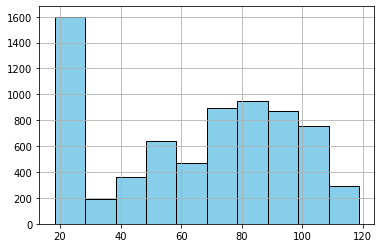

In [41]:
hist(data['monthlycharges'])

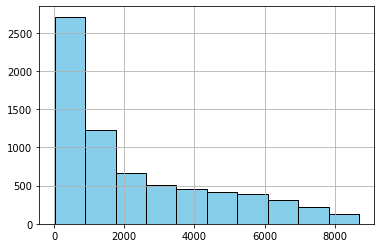

In [42]:
hist(data['totalcharges'])

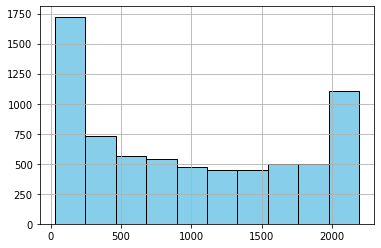

In [43]:
hist(data['sumdays'])

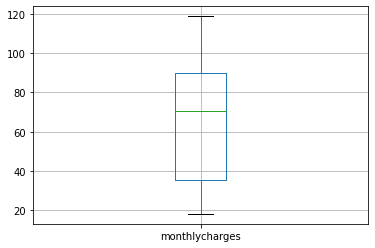

In [44]:
data.boxplot(column='monthlycharges')
plt.show()

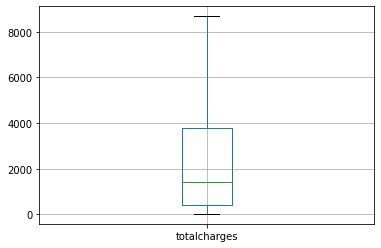

In [45]:
data.boxplot(column='totalcharges')
plt.show()

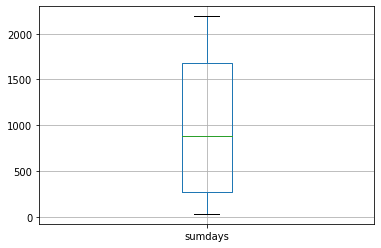

In [46]:
data.boxplot(column='sumdays')
plt.show()

#### Дисбаланс классов

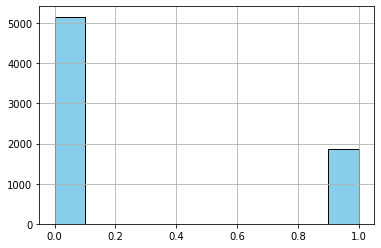

In [47]:
hist(data['out'])

Видим сильный дисбаланс целевого признака, значит необходимо использовать балансировку `class_weight`

### Машинное обучение

In [48]:
from sklearn.pipeline import Pipeline
def take_res(model_name, df = data):
    features = df.drop('out', axis = 1)
    target = df.out
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state=rdm, stratify=target)
    model = model_name
    pipe_model = Pipeline([('sc', StandardScaler()),
        ('mod', model)])
    if "Log" in str(type(model)):
        params = {
                'mod__random_state' : [250722],
                'mod__class_weight' : ['balanced'],
                'mod__C': [1,50,5],
                'mod__solver' : ['liblinear'],
                'mod__max_iter': [500],
                'mod__penalty' : ['l1', 'l2']
            }
        name = 'LogisticRegression'
    elif 'RandomForest' in str(type(model)):
        params = {
                'mod__random_state' : [250722],
                'mod__n_estimators' : [80, 300, 20],
                'mod__class_weight' : ['balanced'],
                'mod__max_depth' : [1,15,5],    
                'mod__criterion' : ['gini', 'entropy']
            }
        name = 'RandomForestClassifier'
    elif 'CatBoost' in str(type(model)):
        params = {
                'mod__random_seed' : [250722],
                'mod__thread_count' : [-1],
                'mod__auto_class_weights' : ['Balanced'],
                'mod__depth' : [10],
                'mod__learning_rate' : [0.4],
                'mod__min_data_in_leaf': [1,2,15],
                'mod__iterations' : [25, 300, 25],
                'mod__logging_level' : ['Silent'],
                'mod__l2_leaf_reg': [3, 6, 9]
            } 
        name = 'CatBoostClassifier'
    elif 'LGBM' in str(type(model)):
        params = {
                'mod__n_estimators': [5, 450, 25],
                'mod__num_leaves': [5,300,25],
                'mod__max_depth' : [5, 50, 5],
                'mod__learning_rate' : [0.4],
                'mod__class_weight': ['balanced'],
                'mod__random_state':[250722],
                'mod__n_jobs' : [3]
            }
        name = 'LGBMClassifier'
    grid = GridSearchCV(pipe_model, params, cv = 5, scoring = 'roc_auc', n_jobs=3, verbose = False)        
    grid.fit(X_train, y_train)
    print('TRAIN ROC-AUC: ', grid.best_score_)
    print('BEST MODEL', grid.best_estimator_)   
    grid.best_estimator_.fit(X_train, y_train)
    prediction = grid.best_estimator_.predict_proba(X_test)[:,1]
    print('TEST ROC-AUC', roc_auc_score(y_test, prediction))
    model.fit(X_train, y_train)

    try:
        sort = model.feature_importances_.argsort()
        plt.barh(X_train.columns[sort], model.feature_importances_[sort])
    except:
        sort = model.coef_[0].argsort()
        plt.barh(X_train.columns[sort], model.coef_[0][sort])
    plt.grid('true')
    plt.title('Значимые для модели признаки '+ name)
    plt.show();



TRAIN ROC-AUC:  0.8405524468162643
BEST MODEL Pipeline(steps=[('sc', StandardScaler()),
                ('mod',
                 LogisticRegression(C=50, class_weight='balanced', max_iter=500,
                                    penalty='l1', random_state=250722,
                                    solver='liblinear'))])
TEST ROC-AUC 0.8334985582722044


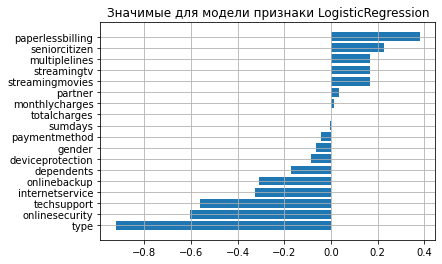

In [50]:
take_res(LogisticRegression())

Вывод: для логистической регрессии наиболее значимыми оказались параметры type,onlinesecurity, techsupport

TRAIN ROC-AUC:  0.9019172058597261
BEST MODEL Pipeline(steps=[('sc', StandardScaler()),
                ('mod',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.4,
                                max_depth=5, n_estimators=450, n_jobs=3,
                                num_leaves=5, random_state=250722))])
TEST ROC-AUC 0.9230189831807051


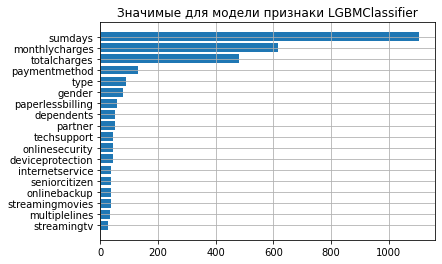

In [51]:
take_res(LGBMClassifier())

Вывод: Наиболее значимымыи для модели LGBM оказались параметры sumdays,monthlycharges, totalcharges

TRAIN ROC-AUC:  0.8709916833350878
BEST MODEL Pipeline(steps=[('sc', StandardScaler()),
                ('mod',
                 <catboost.core.CatBoostClassifier object at 0x7f1d75531100>)])
TEST ROC-AUC 0.8784341334879459
Learning rate set to 0.02154
0:	learn: 0.6770481	total: 3.33ms	remaining: 3.33s
1:	learn: 0.6620672	total: 5.54ms	remaining: 2.76s
2:	learn: 0.6483607	total: 7.6ms	remaining: 2.52s
3:	learn: 0.6357629	total: 9.65ms	remaining: 2.4s
4:	learn: 0.6243472	total: 11.2ms	remaining: 2.23s
5:	learn: 0.6125976	total: 13.3ms	remaining: 2.2s
6:	learn: 0.6026581	total: 15.3ms	remaining: 2.17s
7:	learn: 0.5926680	total: 17.3ms	remaining: 2.14s
8:	learn: 0.5830619	total: 19.3ms	remaining: 2.13s
9:	learn: 0.5734501	total: 21.3ms	remaining: 2.11s
10:	learn: 0.5654110	total: 23.2ms	remaining: 2.09s
11:	learn: 0.5588048	total: 25.2ms	remaining: 2.08s
12:	learn: 0.5515573	total: 27.3ms	remaining: 2.07s
13:	learn: 0.5438096	total: 29.3ms	remaining: 2.06s
14:	learn: 0.5363892	total: 31.3

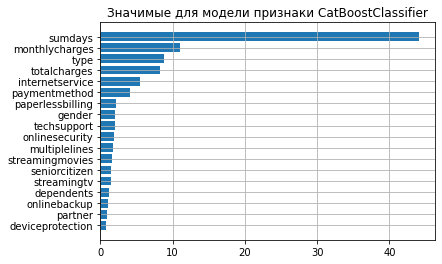

In [52]:
take_res(CatBoostClassifier())

Вывод: Наиболее значимыми парметрами для CatBoost оказались пармтеры sumdays,monthlycharges, type

TRAIN ROC-AUC:  0.8563132151562511
BEST MODEL Pipeline(steps=[('sc', StandardScaler()),
                ('mod',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=5,
                                        n_estimators=300,
                                        random_state=250722))])
TEST ROC-AUC 0.8584803101914884


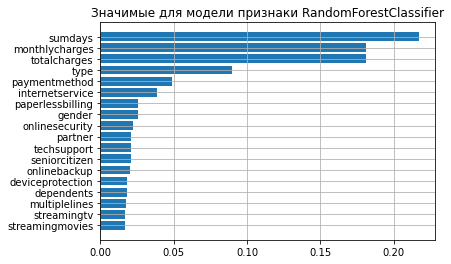

In [53]:
take_res(RandomForestClassifier())

Вывод: наиболее значимые признаки для модели RandomForest оказались sumdays, monthlycharges, totalcharges

### Вывод:наилучшие результаты  на тестовой выборке у модели LGBMClassifier со значением:

### TEST ROC-AUC 0.0.9230189831807051
### TEST accuracy 0.8670931058990761

###  Поставленная задача по потроению модели машинного обучения для прогнозирования ухода клиентов выполнена. Данную модель можно использовать для прогнозирования оттока клиентов и выбирать наиболее правильные промоакции для удержания клиентов. Компания может выгружать данные каждый месяц, находить время жизни клиента и тем самым обеспечаить работы моделей градиентного бустинга.